<a href="https://colab.research.google.com/github/AgustinRamiroDiaz/Algorithmic-Python-Trading/blob/main/RSI_Strat_x_500_Algovibes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install yfinance
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 12.1 MB/s 
     |████████████████████████████████| 1.2 MB 10.8 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 


In [7]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [8]:
# Busco la lista de 500 tickers con sus datos en el site de wikipedia
allTablesInWikipedia = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
tickersWithExtraData = allTablesInWikipedia[0]

In [9]:
# Imprimo la tabla de Wikipedia
tickersWithExtraData

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [10]:
# Solo me interesa la columna 'Symbol'
tickers = tickersWithExtraData['Symbol'].to_list()

In [ ]:
tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIO',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CZR',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP

In [11]:
# los tickers que tienen un punto dan error, entonces los corrijo cambiando el punto por un guion
tickers = [x.replace('.','-') for x in tickers]

In [ ]:
tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRK-B',
 'BBY',
 'BIO',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF-B',
 'CHRW',
 'COG',
 'CDNS',
 'CZR',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP

In [12]:
# Si quiero eliminar un ticker de la lista
tickers.remove('WDC')


# DESCARGA DE DATOS CON YF. DESCOMENTAR DE SER NECESARIO


In [18]:
# fechaDesde = '2018-01-01'
# sp500 = yf.download(tickers, start = fechaDesde)       # No defino 'end' porque llega hasta hoy


In [16]:
# sp500.to_pickle("./SP500-data.pkl")

In [19]:
sp500 = pd.read_pickle("./SP500-data.pkl")

In [21]:
sp500

Adj Close                                                 \
                     A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2018-01-02   65.777748  51.647556  104.796822   41.380238   83.965569   
2018-01-03   67.451401  51.014027  105.745117   41.373032   85.279503   
2018-01-04   66.945419  51.335667  109.646957   41.565216   84.793175   
2018-01-05   68.015762  51.316177  110.812576   42.038452   86.269249   
2018-01-08   68.161713  50.809345  110.032219   41.882305   84.887016   
...                ...        ...         ...         ...         ...   
2021-04-07  129.339996  23.930000  182.619995  127.900002  105.209999   
2021-04-08  130.690002  23.650000  180.500000  130.360001  106.099998   
2021-04-09  131.910004  23.540001  183.970001  133.000000  107.540001   
2021-04-12  131.270004  22.910000  188.059998  131.240005  108.250000   
2021-04-13  132.970001  22.559999  187.410004  134.429993  108.220001   

                                                                        ...  \
                   ABC        ABMD         ABT         ACN        ADBE  ...   
Date                                                                    ...   
2018-01-02   88.732849  192.490005   55.684303  146.372726  177.699997  ...   
2018-01-03   89.063080  195.820007   55.807426  147.048264  181.039993  ...   
2018-01-04   88.864929  199.250000   55.712711  148.789413  183.220001  ...   
2018-01-05   89.940605  202.320007   55.873722  150.016815  185.339996  ...   
2018-01-08   91.431442  207.800003   55.712711  151.215637  185.039993  ...   
...                ...         ...         ...         ...         ...  ...   
2021-04-07  116.480003  320.619995  120.110001  282.570007  493.410004  ...   
2021-04-08  115.449997  329.750000  119.779999  284.420013  499.839996  ...   
2021-04-09  116.809998  333.809998  120.900002  287.709991  504.040009  ...   
2021-04-12  117.540001  333.109985  121.040001  287.540009  506.029999  ...   
2021-04-13  117.120003  329.970001  123.010002  285.220001  514.859985  ...   

               Volume                                                         \
                  XEL       XLNX         XOM       XRAY       XYL        YUM   
Date                                                                           
2018-01-02  2443400.0  2579900.0  11469300.0  1622300.0  877800.0  1747800.0   
2018-01-03  4114900.0  2453300.0  13957700.0  1533300.0  778800.0  2554900.0   
2018-01-04  2807000.0  3346500.0  10863000.0  1052400.0  796500.0  1971200.0   
2018-01-05  3728000.0  5683500.0  11047600.0  1329000.0  666800.0  1927100.0   
2018-01-08  3837600.0  2483100.0  10927100.0  1188500.0  554700.0  1599400.0   
...               ...        ...         ...        ...       ...        ...   
2021-04-07  2343300.0  1782500.0  22385000.0  2048600.0  651300.0  1095600.0   
2021-04-08  2395000.0  4239400.0  21999300.0  1896900.0  554600.0  1216200.0   
2021-04-09  2560200.0  8861700.0  20010100.0  1161100.0  778500.0  1042100.0   
2021-04-12  2887400.0  3529100.0  20234100.0  1221900.0  489000.0  1541900.0   
2021-04-13  2496657.0  1475881.0  13456484.0  2121435.0  405266.0  1288640.0   

                                                       
                  ZBH      ZBRA       ZION        ZTS  
Date                                                   
2018-01-02  1765300.0  310600.0  2387100.0  2135600.0  
2018-01-03  1328800.0  253000.0  1575700.0  2328200.0  
2018-01-04  1073200.0  435200.0  3309200.0  2534000.0  
2018-01-05  1063400.0  301800.0  1212200.0  2166100.0  
2018-01-08  1249500.0  218600.0  1697700.0  3631400.0  
...               ...       ...        ...        ...  
2021-04-07   691400.0  203200.0   659000.0  1660500.0  
2021-04-08   804700.0  268900.0  1319500.0  3440800.0  
2021-04-09  1508400.0  195700.0   981800.0  1821900.0  
2021-04-12  1293700.0  193000.0   914100.0  2916400.0  
2021-04-13   778512.0  188196.0  1

In [20]:
sp500.xs('MMM', axis=1, level=1)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-01-02,212.346481,235.639999,237.070007,232.809998,235.779999,2931000.0
2018-01-03,212.337463,235.630005,235.729996,233.289993,235.070007,2193700.0
2018-01-04,215.113022,238.710007,239.440002,236.470001,237.000000,2243100.0
2018-01-05,216.789154,240.570007,240.899994,237.740005,238.649994,1835900.0
2018-01-08,216.086212,239.789993,240.940002,239.179993,239.380005,1869000.0
...,...,...,...,...,...,...
2021-04-07,194.949997,194.949997,195.350006,193.919998,194.160004,1501500.0
2021-04-08,195.720001,195.720001,196.669998,194.029999,194.419998,2391800.0
2021-04-09,198.000000,198.000000,198.960007,196.059998,196.059998,2159600.0


In [13]:
# Defino una funcion para calcular el indicador.
# Es una funcion que hace todos los calculos y nos devuelve un dataframe con una columna con el resultado para cada linea

def RSIcalc(df):
    df['MA200'] = df['Adj Close'].rolling(window=200).mean()   # agrega una columna para cada dato que necesita para el calculo final
    df['price change'] = df['Adj Close'].pct_change()

    # usa la apply lambda para barrer cada linea del dataframe, en funcion de la columna que elige 
    df['Upmove'] = df['price change'].apply(lambda x: x if x>0 else 0)  #   devuelve x('price change') si es >0 y 0 si no lo es
    df['Downmove'] = df['price change'].apply(lambda x: abs(x) if x<0 else 0)   # misma logica, otra condicion segun estrategia definida
    df['avg Up'] = df['Upmove'].ewm(span=19).mean()    # calcula para las UPmoves la media movil exponencial (ewm) para 19 velas 
    df['avg Down'] = df['Downmove'].ewm(span=19).mean()   # idem para los Downmoves

    df = df.dropna()      # elimina las lineas que tienen valores nan
    df['RS'] = df['avg Up'] / df['avg Down']   # crea una nueva columna con un valor q necesita para el calculo final del indicador
    df['RSI'] = df['RS'].apply(lambda x: 100-(100/(x+1)))  # crea otra columna en el dataframe

    # vamos a definir cuando generar la señal usando el comando df.loc (ubicar)
    # cuando se cumplan las condiciones definidas, genera una columna 'Buy' y le asigna el valor True o False
    df['Buy'] = (df['Adj Close'] > df['MA200']) & (df['RSI'] < 30)
    
    return df

In [22]:
#@title Insertar ticker para ejecutar la función RSIcalc
tickerToProcess = "TSLA" #@param {type:"string"}
dfAsociated = df.xs(tickerToProcess, axis=1, level=1)
dfOutput = RSIcalc(dfAsociated)
dfOutput[dfOutput["Buy"] == True]

,Adj Close,Close,High,Low,Open,Volume,MA200,price change,Upmove,Downmove,avg Up,avg Down,RS,RSI,Buy
Date,,,,,,,,,,,,,,,
2020-03-13,109.323997,109.323997,121.514000,100.400002,119.000000,113201500.0,73.416070,-0.024851,0.0,0.024851,0.015629,0.036653,0.426400,29.893416,True
2020-03-16,89.014000,89.014000,98.973999,88.433998,93.900002,102447500.0,73.672920,-0.185778,0.0,0.185778,0.014066,0.051566,0.272779,21.431755,True
2020-03-17,86.040001,86.040001,94.370003,79.199997,88.001999,119973000.0,73.917960,-0.033410,0.0,0.033410,0.012659,0.049750,0.254460,20.284424,True
2021-02-22,714.500000,714.500000,768.500000,710.200012,762.640015,37269700.0,451.540359,-0.085499,0.0,0.085499,0.006575,0.018873,0.348373,25.836542,True
2021-02-23,698.840027,698.840027,713.609985,619.000000,662.130005,66606900.0,454.254519,-0.021917,0.0,0.021917,0.005917,0.019177,0.308558,23.580026,True
2021-02-26,675.500000,675.500000,706.700012,659.510010,700.000000,41089200.0,462.313099,-0.009850,0.0,0.009850,0.009319,0.022219,0.419406,29.547983,True
2021-03-04,621.440002,621.440002,668.450012,600.000000,655.799988,65919500.0,472.503559,-0.048622,0.0,0.048622,0.010747,0.027405,0.392157,28.169012,True
2021-03-05,597.950012,597.950012,627.840027,539.489990,626.059998,89396500.0,474.685299,-0.037799,0.0,0.037799,0.009672,0.028444,0.340043,25.375547,True
2021-03-08,563.000000,563.000000,620.130005,558.789978,600.549988,51787000.0,476.684739,-0.058450,0.0,0.058450,0.008705,0.031445,0.276836,21.681392,True


# Creamos una nueva funcion  que usa un dataframe como argumento y devuelve las fechas de compra y venta.
# Con esas fechas vamos a poder calcular P&L

In [ ]:
def getSignals(df):
    df['Sell Date'] = ''
    df['Sell Price'] = ''

    # Hacemos loop con i para barrer todas las filas del dataframe
    for i in range(len(df) - 11 ):    # resta 11 xq una condicion de venta es 10 dias despues de la compra
    
        # si hay un 'Yes' en la columna 'Buy', agregamos al dataframe el nombre de la fila (que es la fecha)
        if df['Buy'].iloc[i]:          # ubica la fila con el 'Yes'
            # para buscar la fecha de salida, la condicion es que RSI llegue a un determinado valor antes de los 10 dias
            # entonces usa un nuevo loop j de 1 a 11 (para q incluya hasta el 10)

            for j in range(1, 11):
                if j == 10 or df['RSI'].iloc[i+j] > 40:    # controla desde cada fila i y durante j filas si se cumple la condicion )o( si no se cumple la condicion de venta antes de los 10 dias, vende el dia 10
                    df['Sell Date'].iloc[i] = df.iloc[i+j].name   # si se cumple, agrega la fecha de venta. El +1 idem anterior
                    df['Sell Price'].iloc[i] = df["Adj Close"].iloc[i+j]   # si se cumple, agrega la fecha de venta. El +1 idem anterior
                    break    # corta el loop cuando se cumple la condicion
                # si no se cumple la condicion de venta antes de los 10 dias, vende el dia 10
  

    return df    # devuelve el df original agregando las fechas de venta



In [ ]:
# tambien define buy y sell que llaman a la funcion getSignals
frame = getSignals(dfOutput)

frame["Profit"] = 0
frame.loc[frame['Buy'] == True, 'Profit'] = (frame.loc[frame['Buy'] == True]["Sell Price"] - frame.loc[frame['Buy'] == True]["Adj Close"]) / frame.loc[frame['Buy'] == True]["Adj Close"]

frame[frame["Buy"] == True][['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI',
       'Buy', 'Sell Date', 'Sell Price', 'Profit']]


,Adj Close,Close,High,Low,Open,Volume,RSI,Buy,Sell Date,Sell Price,Profit
Date,,,,,,,,,,,
2020-03-13,109.323997,109.323997,121.514000,100.400002,119.000000,113201500.0,29.893416,True,2020-03-24 00:00:00,101,-0.0761406
2020-03-16,89.014000,89.014000,98.973999,88.433998,93.900002,102447500.0,21.431755,True,2020-03-24 00:00:00,101,0.134653
2020-03-17,86.040001,86.040001,94.370003,79.199997,88.001999,119973000.0,20.284424,True,2020-03-24 00:00:00,101,0.173873
2021-02-22,714.500000,714.500000,768.500000,710.200012,762.640015,37269700.0,25.836542,True,2021-03-01 00:00:00,718.43,0.00550034
2021-02-23,698.840027,698.840027,713.609985,619.000000,662.130005,66606900.0,23.580026,True,2021-03-01 00:00:00,718.43,0.0280321
2021-02-26,675.500000,675.500000,706.700012,659.510010,700.000000,41089200.0,29.547983,True,2021-03-01 00:00:00,718.43,0.0635529
2021-03-04,621.440002,621.440002,668.450012,600.000000,655.799988,65919500.0,28.169012,True,2021-03-09 00:00:00,673.58,0.0839019
2021-03-05,597.950012,597.950012,627.840027,539.489990,626.059998,89396500.0,25.375547,True,2021-03-09 00:00:00,673.58,0.126482
2021-03-08,563.000000,563.000000,620.130005,558.789978,600.549988,51787000.0,21.681392,True,2021-03-09 00:00:00,673.58,0.196412


In [ ]:
sellDates = frame[frame["Buy"] == True]["Sell Date"]
buyDates = frame[frame["Buy"] == True].axes[0]


buyDates
sellDates

Date
2020-03-13    2020-03-24 00:00:00
2020-03-16    2020-03-24 00:00:00
2020-03-17    2020-03-24 00:00:00
2021-02-22    2021-03-01 00:00:00
2021-02-23    2021-03-01 00:00:00
2021-02-26    2021-03-01 00:00:00
2021-03-04    2021-03-09 00:00:00
2021-03-05    2021-03-09 00:00:00
2021-03-08    2021-03-09 00:00:00
Name: Sell Date, dtype: object

In [ ]:
frame.loc[sellDates]

,Adj Close,Close,High,Low,Open,Volume,MA200,price change,Upmove,Downmove,avg Up,avg Down,RS,RSI,Buy,Sell Date,Sell Price,Profit
Date,,,,,,,,,,,,,,,,,,
2020-03-24,101.000000,101.000000,102.737999,94.800003,95.459999,114476000.0,75.094030,0.162817,0.162817,0.0,0.038585,0.039918,0.966599,49.150784,False,,,0
2020-03-24,101.000000,101.000000,102.737999,94.800003,95.459999,114476000.0,75.094030,0.162817,0.162817,0.0,0.038585,0.039918,0.966599,49.150784,False,,,0
2020-03-24,101.000000,101.000000,102.737999,94.800003,95.459999,114476000.0,75.094030,0.162817,0.162817,0.0,0.038585,0.039918,0.966599,49.150784,False,,,0
2021-03-01,718.429993,718.429993,719.000000,685.049988,690.109985,27136200.0,465.114289,0.063553,0.063553,0.0,0.014742,0.019997,0.737222,42.436847,False,,,0
2021-03-01,718.429993,718.429993,719.000000,685.049988,690.109985,27136200.0,465.114289,0.063553,0.063553,0.0,0.014742,0.019997,0.737222,42.436847,False,,,0
2021-03-01,718.429993,718.429993,719.000000,685.049988,690.109985,27136200.0,465.114289,0.063553,0.063553,0.0,0.014742,0.019997,0.737222,42.436847,False,,,0
2021-03-09,673.580017,673.580017,678.090027,595.210022,608.179993,67523300.0,479.225039,0.196412,0.196412,0.0,0.027476,0.028300,0.970865,49.260869,False,,,0
2021-03-09,673.580017,673.580017,678.090027,595.210022,608.179993,67523300.0,479.225039,0.196412,0.196412,0.0,0.027476,0.028300,0.970865,49.260869,False,,,0
2021-03-09,673.580017,673.580017,678.090027,595.210022,608.179993,67523300.0,479.225039,0.196412,0.196412,0.0,0.027476,0.028300,0.970865,49.260869,False,,,0


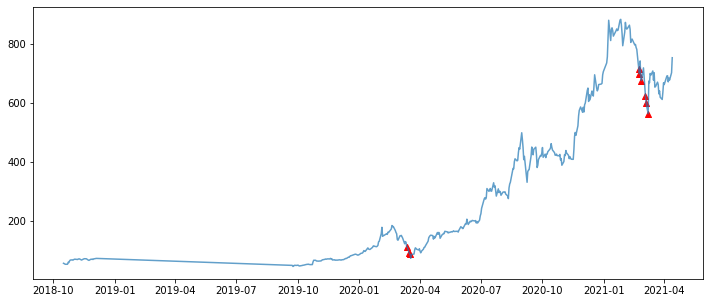

In [ ]:
# mostramos las señales de compra
plt.figure(figsize=(12,5))# tamano del plot
plt.scatter(
    frame.loc[buyDates].index, 
    frame.loc[buyDates]['Adj Close'], 
    marker = '^', 
    c='r'
    )
plt.plot(frame['Adj Close'], alpha = 0.7)


In [ ]:
frame["Win"] = frame["Profit"] > 0
frame

,Adj Close,Close,High,Low,Open,Volume,MA200,price change,Upmove,Downmove,avg Up,avg Down,RS,RSI,Buy,Sell Date,Sell Price,Profit,Win
Date,,,,,,,,,,,,,,,,,,,
2018-10-16,55.318001,55.318001,55.476002,52.448002,53.139999,47632000.0,62.585200,0.065488,0.065488,0.000000,0.020092,0.018176,1.105427,52.503707,False,,,0,False
2018-10-17,54.355999,54.355999,56.540001,53.160000,56.480000,43277500.0,62.536450,-0.017390,0.000000,0.017390,0.018083,0.018097,0.999204,49.980087,False,,,0,False
2018-10-18,52.782001,52.782001,54.200001,52.599998,53.858002,27106000.0,62.483110,-0.028957,0.000000,0.028957,0.016275,0.019183,0.848375,45.898432,False,,,0,False
2018-10-19,52.000000,52.000000,53.931999,50.700001,53.478001,46877500.0,62.428490,-0.014816,0.000000,0.014816,0.014647,0.018747,0.781327,43.862088,False,,,0,False
2018-10-22,52.189999,52.189999,52.372002,50.518002,52.136002,28001500.0,62.372860,0.003654,0.003654,0.000000,0.013548,0.016872,0.802983,44.536374,False,,,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-07,670.969971,670.969971,691.380005,667.840027,687.000000,26309400.0,527.461199,-0.029857,0.000000,0.029857,0.016107,0.014547,1.107231,52.544367,False,,,0,False
2021-04-08,683.799988,683.799988,689.549988,671.650024,677.380005,23924300.0,529.885879,0.019122,0.019122,0.000000,0.016409,0.013093,1.253280,55.620258,False,,,0,False
2021-04-09,677.020020,677.020020,680.969971,669.429993,677.770020,21437100.0,532.269199,-0.009915,0.000000,0.009915,0.014768,0.012775,1.156008,53.617975,False,,,0,False


In [ ]:
wins = frame[frame["Win"] == True]
wins

,Adj Close,Close,High,Low,Open,Volume,MA200,price change,Upmove,Downmove,avg Up,avg Down,RS,RSI,Buy,Sell Date,Sell Price,Profit,Win
Date,,,,,,,,,,,,,,,,,,,
2020-03-16,89.014000,89.014000,98.973999,88.433998,93.900002,102447500.0,73.672920,-0.185778,0.0,0.185778,0.014066,0.051566,0.272779,21.431755,True,2020-03-24 00:00:00,101,0.134653,True
2020-03-17,86.040001,86.040001,94.370003,79.199997,88.001999,119973000.0,73.917960,-0.033410,0.0,0.033410,0.012659,0.049750,0.254460,20.284424,True,2020-03-24 00:00:00,101,0.173873,True
2021-02-22,714.500000,714.500000,768.500000,710.200012,762.640015,37269700.0,451.540359,-0.085499,0.0,0.085499,0.006575,0.018873,0.348373,25.836542,True,2021-03-01 00:00:00,718.43,0.00550034,True
2021-02-23,698.840027,698.840027,713.609985,619.000000,662.130005,66606900.0,454.254519,-0.021917,0.0,0.021917,0.005917,0.019177,0.308558,23.580026,True,2021-03-01 00:00:00,718.43,0.0280321,True
2021-02-26,675.500000,675.500000,706.700012,659.510010,700.000000,41089200.0,462.313099,-0.009850,0.0,0.009850,0.009319,0.022219,0.419406,29.547983,True,2021-03-01 00:00:00,718.43,0.0635529,True
2021-03-04,621.440002,621.440002,668.450012,600.000000,655.799988,65919500.0,472.503559,-0.048622,0.0,0.048622,0.010747,0.027405,0.392157,28.169012,True,2021-03-09 00:00:00,673.58,0.0839019,True
2021-03-05,597.950012,597.950012,627.840027,539.489990,626.059998,89396500.0,474.685299,-0.037799,0.0,0.037799,0.009672,0.028444,0.340043,25.375547,True,2021-03-09 00:00:00,673.58,0.126482,True
2021-03-08,563.000000,563.000000,620.130005,558.789978,600.549988,51787000.0,476.684739,-0.058450,0.0,0.058450,0.008705,0.031445,0.276836,21.681392,True,2021-03-09 00:00:00,673.58,0.196412,True


In [ ]:
len(wins) / len(frame[frame["Buy"] == True])

0.8888888888888888

In [ ]:
len(frame[frame["Buy"] == True])   # cantidad de transacciones

9

In [ ]:
# Ahora pasemos a las 500 tickers

matrixsignals = []
matrixprofits = []

for i in range(len(tickers)):
  frame = RSIcalc(tickers[i])
  buy, sell = getSignals(frame)
  Profits = (frame.loc[sell].Open.values -frame.loc[buy].Open.values)/ frame.loc[buy].Open.values
  matrixsignals.append(buy)
  matrixprofits.append(Profits)


[*********************100%***********************]  1 of 1 completed


TypeError: ignored

In [ ]:
matrixsignals

[[Timestamp('2021-01-12 00:00:00')],
 [Timestamp('2018-12-26 00:00:00'),
  Timestamp('2019-04-18 00:00:00'),
  Timestamp('2019-04-22 00:00:00'),
  Timestamp('2020-02-25 00:00:00')],
 [Timestamp('2020-01-27 00:00:00'),
  Timestamp('2020-01-29 00:00:00'),
  Timestamp('2020-01-30 00:00:00'),
  Timestamp('2020-01-31 00:00:00'),
  Timestamp('2020-02-03 00:00:00'),
  Timestamp('2020-03-13 00:00:00'),
  Timestamp('2020-08-07 00:00:00')],
 [Timestamp('2020-09-08 00:00:00'),
  Timestamp('2020-09-09 00:00:00'),
  Timestamp('2021-03-05 00:00:00'),
  Timestamp('2021-03-09 00:00:00')],
 [Timestamp('2019-05-14 00:00:00'),
  Timestamp('2019-08-06 00:00:00'),
  Timestamp('2019-10-03 00:00:00'),
  Timestamp('2020-02-26 00:00:00'),
  Timestamp('2020-02-27 00:00:00'),
  Timestamp('2020-09-25 00:00:00'),
  Timestamp('2020-09-28 00:00:00')],
 [Timestamp('2020-09-09 00:00:00')],
 [Timestamp('2019-08-06 00:00:00'),
  Timestamp('2020-02-28 00:00:00'),
  Timestamp('2020-03-10 00:00:00'),
  Timestamp('2020-11-0

In [ ]:
matrixprofits

[array([0.01892706]),
 array([ 0.03808804,  0.03272683,  0.03992897, -0.03944423]),
 array([ 0.00011751,  0.01503573,  0.03003143,  0.04316896,  0.04611979,
        -0.05230327,  0.02643216]),
 array([0.02728042, 0.01382741, 0.01295108, 0.03039655]),
 array([ 0.00174512,  0.00289285,  0.01602626, -0.14773238, -0.2039542 ,
         0.04853775,  0.01953535]),
 array([0.03134236]),
 array([0.04410679, 0.1150977 , 0.01674085, 0.1070288 , 0.11198468]),
 array([0.11357493, 0.13069748, 0.15221036, 0.15904366, 0.18544483]),
 array([-0.02399998, -0.01606706,  0.00566721,  0.03028301,  0.03396679,
         0.04301364,  0.01828711,  0.05318054,  0.0594326 ,  0.05210152,
         0.03669299]),
 array([ 0.03106939, -0.04391101, -0.06604331, -0.04033216, -0.0350773 ,
        -0.025733  , -0.00482509,  0.03448277,  0.0248447 ,  0.02548166,
         0.01041029,  0.03254071, -0.24268854, -0.29633616, -0.18812501]),
 array([0.001325  , 0.00170423, 0.00608596, 0.01166572, 0.01848292,
        0.02878264, 

In [ ]:
len(matrixprofits)

504

In [ ]:
# Crea una lista 'allprofit'
allprofit = []

for i in matrixprofits:
  for e in i:
    allprofit.append(e)

In [ ]:
wins = [i for i in allprofit if i>0]

In [ ]:
len(wins)/len(allprofit)

0.7402422611036339

<function matplotlib.pyplot.show>

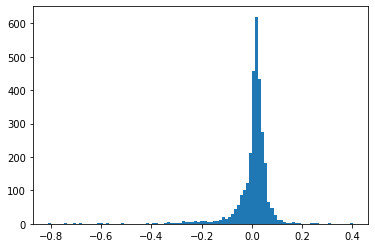

In [ ]:
plt.hist(allprofit, bins=100)
plt.show

In [ ]:
for i in matrixsignals:
  for e in i:
    if e.year == 2021:
      print(e)

2021-01-12 00:00:00
2021-03-05 00:00:00
2021-03-09 00:00:00
2021-01-28 00:00:00
2021-03-05 00:00:00
2021-02-19 00:00:00
2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-09 00:00:00
2021-02-01 00:00:00
2021-02-17 00:00:00
2021-02-23 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-28 00:00:00
2021-02-26 00:00:00
2021-01-28 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-03-01 00:00:00
2021-03-09 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-03-01 00:00:00
2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-08 00:00:00
2021-03-09 00:00:00
2021-01-28 00:00:00
2021-02-19 00:00:00
2021-01-28 00:00:00
2021-01-15 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-22 00:00:00
2021-02-01 00:00:00
2021-01-28 00:00:00
2021-03-05 00:00:00
2021-01-28 00:00:00
2021-02-26 00:00:00
2021-01-28 00:00:00
2021-01-05 00:00:00
2021-01-28 00:00:00
2021-01-27 00:00:00
